In [ ]:
# Import necessary packages

import numpy as np
import torch 
import torch.nn as nn 
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os 
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import normalize
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# Navigate to directory that stores all the files - will need to be changed for each person running this script
os.chdir('/home/ian/Documents/Penn_Fall_2020/CIS_519/CIS 519 Audio Classification Project Local Files')
os.getcwd()

In [ ]:
# Reload features (takes a couple minutes)
# features = np.load('features_with_gender.npy',allow_pickle=True)
features = np.load('features/features_spectrogram.npy',allow_pickle=True)

In [ ]:
# Changing array type of features (Necessary for it to work with pytorch)

features = [example for example in features]

In [ ]:
# Load in labels 
labels = np.load('labels.npy', allow_pickle=True)

In [ ]:
# Load in gender
gender=np.load('gender.npy',allow_pickle=True)

In [ ]:
# Turn labels into numeric values, create dictionary to map back later 

labels_unique = np.unique(labels)
labels_dict = {}
for i in range (0, len(labels_unique)):
    labels_dict.update({i:labels_unique[i]})

labels_dict_reversed = {value:key for key, value in labels_dict.items()}

def label_to_num(x):
    return labels_dict_reversed[x]

labels_numeric = [label_to_num(country) for country in labels]

#### Split into train and test sets: ZERO-SHOT

In [ ]:
features_male = []
labels_male = []
features_female = []
labels_female = []

for i in range(len(gender)):
    if gender[i] == 0:
        features_male.append(features[i])
        labels_male.append(labels[i])
    else:
        features_female.append(features[i])
        labels_female.append(labels[i])
        
features_male = np.array(features_male)
features_female = np.array(features_female)
labels_male = np.array(labels_male)
labels_female = np.array(labels_female)

In [ ]:
# Get train and test datasets
x_train, x_valid, y_train, y_valid = train_test_split(features_male, labels_male, test_size=0.3, random_state=42)
_, x_test, _, y_test = train_test_split(features_female, labels_female, test_size=0.3, random_state=142)

In [10]:
# Balance training data 

for y in labels_unique:
    print(str(y) + ' , Occurences: ' + str(list(labels).count(y)))
    
x_train_balanced = []
x_valid_balanced = []
y_train_balanced = []
y_valid_balanced = []
x_test_balanced = []
y_test_balanced = []

remap={}
keep = [0,1,6,7,8,12,13,18,19]

for i in range(0, len(keep)):
    remap[keep[i]] = i
    
print(remap)

    
for i in range(0, len(y_train)):
    if y_train[i] in keep:
        y_train_balanced.append(remap[y_train[i]])
        x_train_balanced.append(x_train[i])
        
for i in range(0, len(y_valid)):
    if y_valid[i] in keep:
        y_valid_balanced.append(remap[y_valid[i]])
        x_valid_balanced.append(x_valid[i])
        
for i in range(0, len(y_test)):
    if y_test[i] in keep:
        y_test_balanced.append(remap[y_test[i]])
        x_test_balanced.append(x_test[i])
        



0 , Occurences: 500
1 , Occurences: 500
2 , Occurences: 91
3 , Occurences: 188
4 , Occurences: 144
5 , Occurences: 141
6 , Occurences: 500
7 , Occurences: 500
8 , Occurences: 500
9 , Occurences: 274
10 , Occurences: 392
11 , Occurences: 159
12 , Occurences: 500
13 , Occurences: 500
14 , Occurences: 243
15 , Occurences: 118
16 , Occurences: 88
17 , Occurences: 292
18 , Occurences: 500
19 , Occurences: 500
{0: 0, 1: 1, 6: 2, 7: 3, 8: 4, 12: 5, 13: 6, 18: 7, 19: 8}


In [11]:
# Initializing number of outputs for neural network

output_label_num = len(labels_unique)

In [12]:
output_label_num

20

In [23]:
# Convolutional 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=10,kernel_size=3,stride=1,padding=0)
        self.fc1 = nn.Linear(10*254*10*1, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, output_label_num)
        self.dropout = nn.Dropout(p=.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 1*x.size()[1]*x.size()[2]*x.size()[3])
#         x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class BalancedNet(nn.Module):
    def __init__(self):
        super(BalancedNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=15,kernel_size=3,stride=1,padding=0)
        self.fc1 = nn.Linear(15*254*10*1, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, len(keep))
        self.dropout = nn.Dropout(p=.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout(x)
        x = x.view(-1, 1*x.size()[1]*x.size()[2]*x.size()[3])
#         x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    

In [24]:
def compute_loss_and_accuracy(network, data_loader):
    total_loss = 0
    num_correct = 0
    num_instances = 0

    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    for X, y in data_loader:
        with torch.no_grad():
            y_pred = network(X)
            total_loss += cross_entropy_loss(y_pred,y).item() * X.size(0)

        for i in range(len(y_pred)):
            predicted = torch.argmax(y_pred[i])
            actual = y[i]

            if predicted == actual:
                num_correct += 1
                
        num_instances += X.size(0)
  
    accuracy = num_correct / num_instances
    average_loss = total_loss / num_instances

    return accuracy, average_loss

In [25]:
# Creating function to compute loss/accuracy

def test_model(net, test_dataloader):

    total_loss = 0
    total_classified_correct = 0
    total_attempted = 0
    pred_vs_actual = []

    criterion = nn.CrossEntropyLoss()

    for x, y in test_dataloader:
        output = net(x)
        _, predicted = torch.max(output, 1)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_classified_correct += (predicted==y).sum().item()
        total_attempted += len(predicted)
        pred_vs_actual.append((predicted.item(), y.item()))
        
    print('Test Average Loss: ' + str(total_loss/total_attempted))
    print('Test Accuracy: ' + str(total_classified_correct/total_attempted))
    
    
    return total_attempted, pred_vs_actual

In [26]:
def check_preds(pred_vs_acc):
    pred_list = []
    acc_list = []
    total_list = []
    for pred, acc in pred_vs_acc:
        pred_list.append(pred)
        acc_list.append(acc)
        total_list.append(1)
        
    df = pd.DataFrame({'predicted':pred_list, 'actual':acc_list, 'total':total_list})
    df = df.groupby(['predicted', 'actual']).count().reset_index()
    
    def get_correct(row):
        if row.predicted==row.actual:
            return 1 
        else:
            return 0
        
    df['is_correct'] = df.apply(lambda x: get_correct(x), axis=1)
    df['predicted_country'] = df.predicted.apply(lambda x: labels_dict[x])
    df['actual_country'] = df.actual.apply(lambda x: labels_dict[x])
    
    return df

In [27]:
# Creating training function

def train_model(epochs, net, train_dataloader, valid_dataloader, optimizer, criterion):

    train_loss_per_epoch = []
    train_acc_per_epoch = []
    valid_acc_per_epoch = []

    for epoch in range (0, epochs):

        train_total_loss = 0
        train_total_correct = 0
        train_total_attempted = 0

        for x, y in train_dataloader:
            optimizer.zero_grad()
            output = net(x)
            _, predicted = torch.max(output, 1)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        
        train_acc, train_loss = compute_loss_and_accuracy(net, train_dataloader)
        valid_acc, valid_loss = compute_loss_and_accuracy(net, valid_dataloader)
        
        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)
        valid_acc_per_epoch.append(valid_acc)

    
        print('Epoch ' + str(epoch) + ':')
        print('Train Average Loss: ' + str(train_loss))
        print('Train Accuracy: ' + str(train_acc))
        print('Validation Average Loss: ' + str(valid_loss))
        print('Validation Accuracy: ' + str(valid_acc))
        print()


    return train_acc_per_epoch, valid_acc_per_epoch

# train_model(1, net, train_dataloader, optimizer, criterion)

In [28]:
# Create dataloader objects, move to GPU

batch = 32

# Train
x_train_tensor = torch.tensor(x_train, dtype=torch.float)
x_train_tensor = x_train_tensor.unsqueeze(dim=1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_train_tensor = x_train_tensor.cuda()
y_train_tensor = y_train_tensor.cuda()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch)

# Validation
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float)
x_valid_tensor = x_valid_tensor.unsqueeze(dim=1)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

x_valid_tensor = x_valid_tensor.cuda()
y_valid_tensor = y_valid_tensor.cuda()

valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch)

# Test
x_test_tensor = torch.tensor(x_test, dtype=torch.float)
x_test_tensor = x_test_tensor.unsqueeze(dim=1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

x_test_tensor = x_test_tensor.cuda()
y_test_tensor = y_test_tensor.cuda()

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=1)


Epoch 0:
Train Average Loss: 2.793586896903248
Train Accuracy: 0.11046931407942238
Validation Average Loss: 2.8056925723849724
Validation Accuracy: 0.09932659932659933

Epoch 1:
Train Average Loss: 2.7658033532786455
Train Accuracy: 0.12057761732851986
Validation Average Loss: 2.776232860706471
Validation Accuracy: 0.10858585858585859

Epoch 2:
Train Average Loss: 2.7501170120514686
Train Accuracy: 0.1259927797833935
Validation Average Loss: 2.7649899693049163
Validation Accuracy: 0.117003367003367

Epoch 3:
Train Average Loss: 2.7304619016199765
Train Accuracy: 0.13212996389891696
Validation Average Loss: 2.7469621651903147
Validation Accuracy: 0.12205387205387205

Epoch 4:
Train Average Loss: 2.7150446962363453
Train Accuracy: 0.14296028880866427
Validation Average Loss: 2.736565953553325
Validation Accuracy: 0.13552188552188552

Epoch 5:
Train Average Loss: 2.6995455228895056
Train Accuracy: 0.15379061371841155
Validation Average Loss: 2.7245110229209617
Validation Accuracy: 0.13636

Epoch 49:
Train Average Loss: 0.3266903252700606
Train Accuracy: 0.9194945848375451
Validation Average Loss: 5.257732645028368
Validation Accuracy: 0.1388888888888889



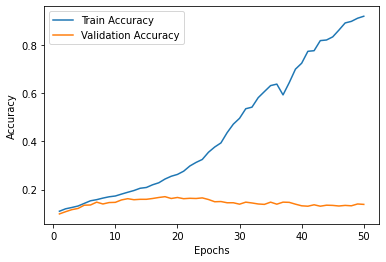

In [29]:
# Initializing model, parameters, move to GPU

net = Net()
net = net.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train Model
epochs = 50
train_accs, valid_accs = train_model(epochs, net, train_dataloader, valid_dataloader, optimizer, criterion)

epoch_list = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_list, train_accs, label='Train Accuracy')
plt.plot(epoch_list, valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
pred_vs_acc = test_model(net, test_dataloader)[1]

Test Average Loss: 7.483774649828893
Test Accuracy: 0.08104738154613467


In [22]:
check_preds(pred_vs_acc)[check_preds(pred_vs_acc)['is_correct']==1].sort_values(by='total', ascending=False)

,predicted,actual,total,is_correct,predicted_country,actual_country
139,10,10,12,1,10,10
91,6,6,10,1,6,6
168,12,12,9,1,12,12
248,19,19,6,1,19,19
74,5,5,4,1,5,5
0,0,0,3,1,0,0
195,14,14,3,1,14,14
19,1,1,2,1,1,1
151,11,11,2,1,11,11
36,2,2,1,1,2,2


In [ ]:
check_preds(pred_vs_acc)[check_preds(pred_vs_acc)['is_correct']==0].sort_values(by='total', ascending=False)

In [ ]:
# For balanced experiment

# Create dataloader objects, move to GPU

# Train
x_train_balanced_tensor = torch.tensor(x_train_balanced, dtype=torch.float)
x_train_balanced_tensor = x_train_balanced_tensor.unsqueeze(dim=1)
y_train_balanced_tensor = torch.tensor(y_train_balanced, dtype=torch.long)

x_train_balanced_tensor = x_train_balanced_tensor.cuda()
y_train_balanced_tensor = y_train_balanced_tensor.cuda()

train_balanced_dataset = TensorDataset(x_train_balanced_tensor, y_train_balanced_tensor)
train_balanced_dataloader = DataLoader(train_balanced_dataset, batch_size=batch)

# Validation
x_valid_balanced_tensor = torch.tensor(x_valid_balanced, dtype=torch.float)
x_valid_balanced_tensor = x_valid_balanced_tensor.unsqueeze(dim=1)
y_valid_balanced_tensor = torch.tensor(y_valid_balanced, dtype=torch.long)

x_valid_balanced_tensor = x_valid_balanced_tensor.cuda()
y_valid_balanced_tensor = y_valid_balanced_tensor.cuda()

valid_balanced_dataset = TensorDataset(x_valid_balanced_tensor, y_valid_balanced_tensor)
valid_balanced_dataloader = DataLoader(valid_balanced_dataset, batch_size=batch)

# Test
x_test_balanced_tensor = torch.tensor(x_test_balanced, dtype=torch.float)
x_test_balanced_tensor = x_test_balanced_tensor.unsqueeze(dim=1)
y_test_balanced_tensor = torch.tensor(y_test_balanced, dtype=torch.long)

x_test_balanced_tensor = x_test_balanced_tensor.cuda()
y_test_balanced_tensor = y_test_balanced_tensor.cuda()

test_balanced_dataset = TensorDataset(x_test_balanced_tensor, y_test_balanced_tensor)
test_balanced_dataloader = DataLoader(test_balanced_dataset, batch_size=1)


In [ ]:
# Initializing model, parameters, move to GPU

net = BalancedNet()
net = net.cuda()

batch = 32
optimizer = optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train Model
epochs = 50
train_accs, valid_accs = train_model(epochs, net, train_balanced_dataloader, valid_balanced_dataloader, optimizer, criterion)

epoch_list = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_list, train_accs, label='Train Accuracy')
plt.plot(epoch_list, valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pred_vs_acc = test_model(net, test_balanced_dataloader)[1]

In [ ]:
check_preds(pred_vs_acc)[check_preds(pred_vs_acc)['is_correct']==1].sort_values(by='total', ascending=False)